# Introduction

### In this notebook we use [UNet](https://arxiv.org/abs/1505.04597) segmentation model for performing building segmentation on [Massachusetts Buildings Dataset](https://www.cs.toronto.edu/~vmnih/docs/Mnih_Volodymyr_PhD_Thesis.pdf).

### This Code Reference from Github lostmartian

### https://github.com/lostmartian/Building-and-Road-Segmentation-from-Aerial-Images/blob/main/notebooks/building/B7.ipynb

# Tutorial How to Use this kind of Training:

## 1. Download the Datasets from this link below
### https://www.kaggle.com/datasets/balraj98/massachusetts-buildings-dataset

## 2. Find this word: drive/MyDrive in this Google Collab
### - then replace with your downloaded Datasets location path
### - Example if you put the downloaded dataset on `D:/Program Files/` then
### the path become like this : `D:/Program Files`/massachusetts-building-dataset/tiff/

## 3. Execute all the code step by step

### Libraries 📚⬇

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
# import segmentation_models_pytorch as smp
# import segmentation_models_pytorch.utils.metrics

!pip install -q git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 79.1 MB/s eta 0:00:00


### Defining train / val / test directories 📁

In [ ]:
# DATA_DIR = '../input/massachusetts-buildings-dataset/tiff/'
DATA_DIR = 'drive/MyDrive/massachusetts-building-dataset/tiff/'
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

print("x_train_dir",x_train_dir)
print("y_train_dir",y_train_dir)

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

x_train_dir drive/MyDrive/massachusetts-building-dataset/tiff/train
y_train_dir drive/MyDrive/massachusetts-building-dataset/tiff/train_labels


In [ ]:
class_dict = pd.read_csv("drive/MyDrive/massachusetts-building-dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Shortlist specific classes to segment

In [ ]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Helper functions for viz. & one-hot encoding/decoding

In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
#     print(semantic_map)
#     print(semantic_map.shape)
    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
#     print(x)
#     print(x.shape)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

#### Visualize Sample Image and Mask 📈

len(dataset) 137
random_idx 81


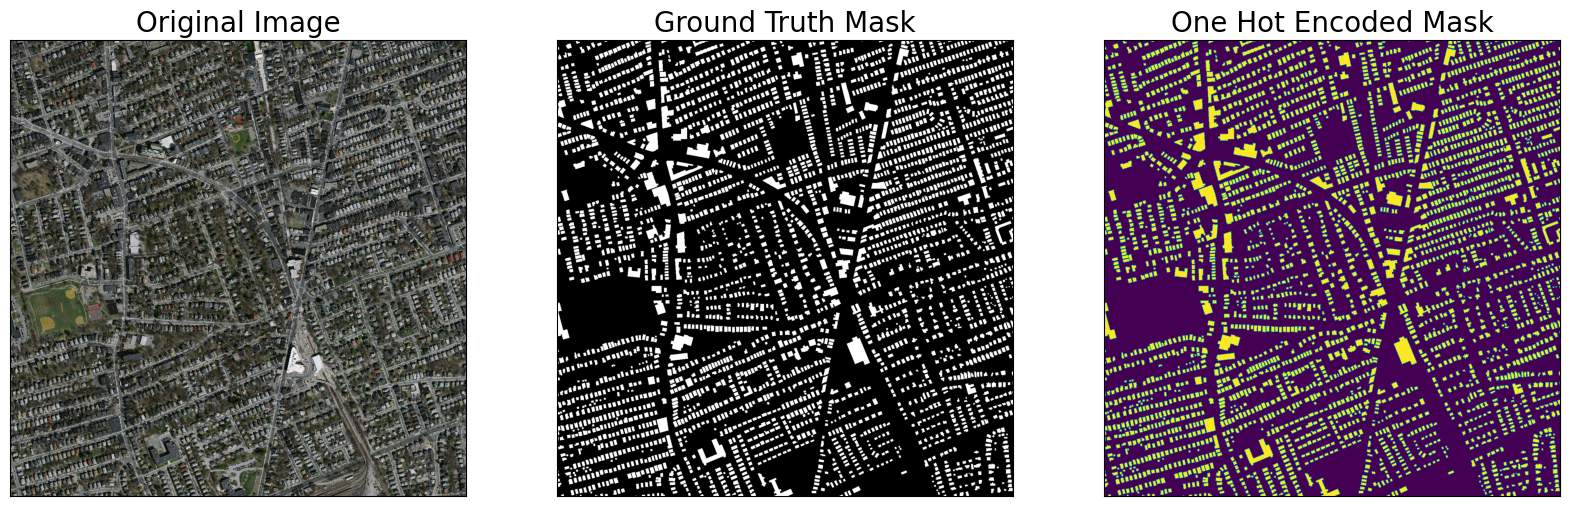

In [ ]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)

print("len(dataset)",len(dataset))
print("random_idx",random_idx)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Defining Augmentations 🙃

In [ ]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

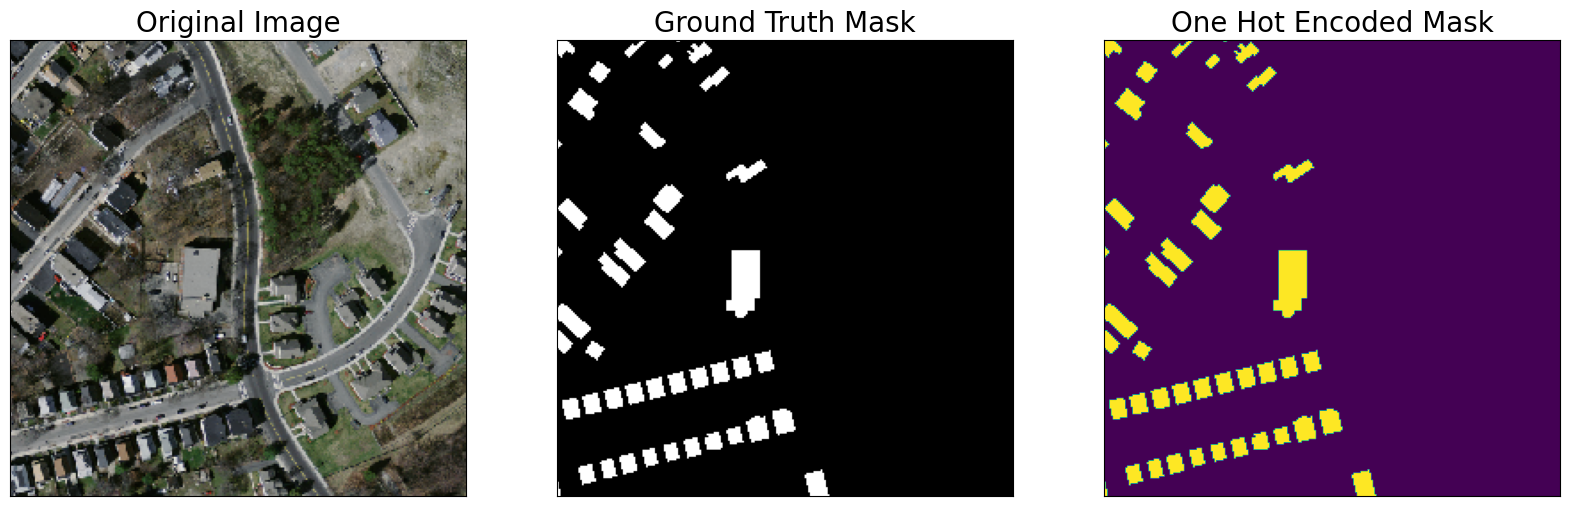

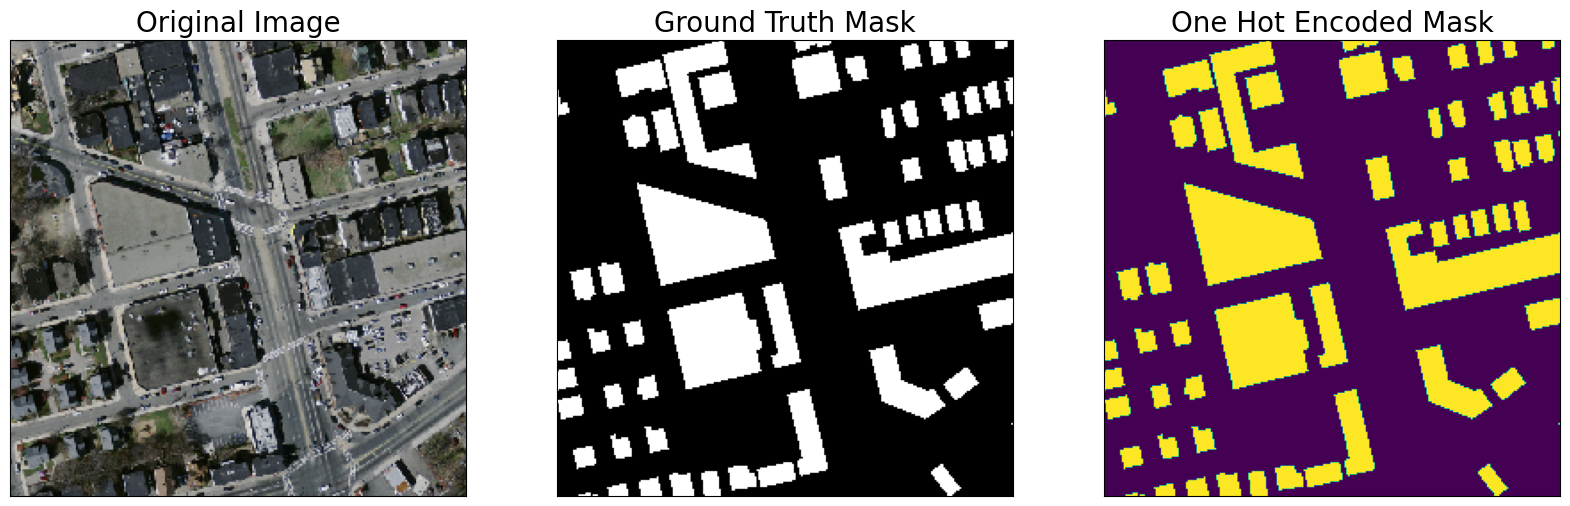

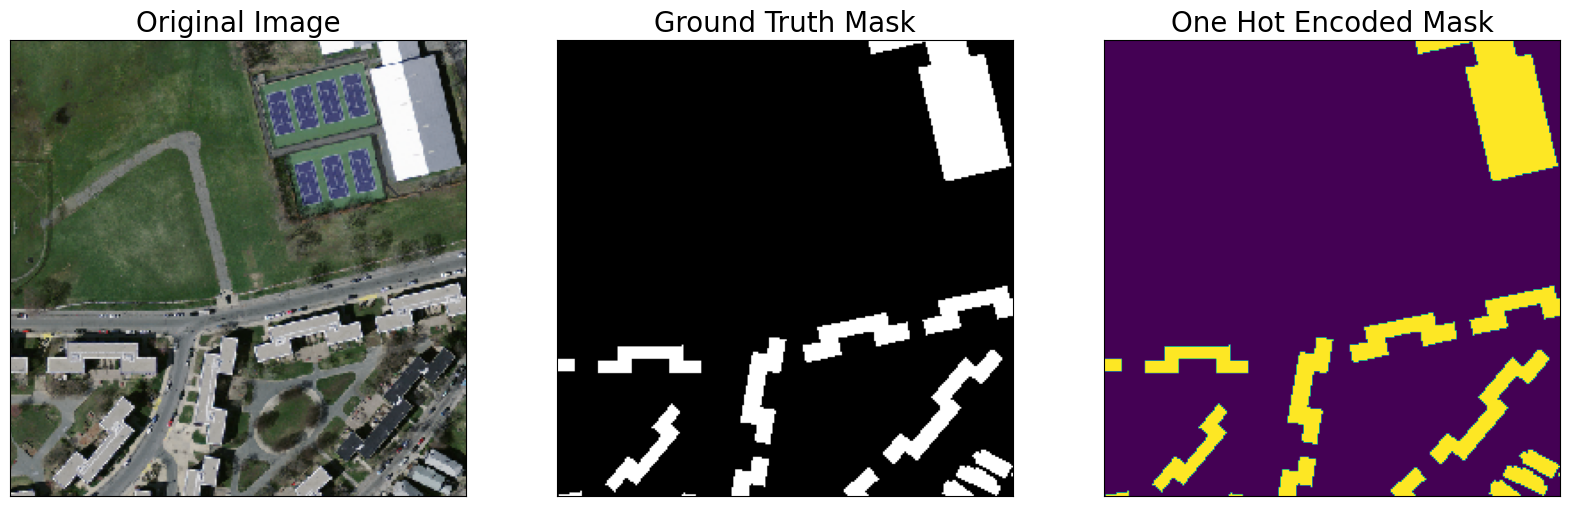

In [ ]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Training UNet with Pretrained EfficientNet-B7 Encoder

### Model Definition

In [ ]:
ENCODER = 'efficientnet-b7'
# ENCODER = 'mit_b5'
# ENCODER = 'tu-tf_efficientnetv2_l'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

import torch
from torchsummary import summary

# Convert the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Provide input shape information to the summary function
# Assuming input shape is (batch_size, channels, height, width)
input_shape = (3, 256, 256)

# Generate the summary
summary(model, input_shape)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:01<00:00, 229MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 257, 257]               0
Conv2dStaticSamePadding-2         [-1, 64, 128, 128]           1,728
       BatchNorm2d-3         [-1, 64, 128, 128]             128
MemoryEfficientSwish-4         [-1, 64, 128, 128]               0
         ZeroPad2d-5         [-1, 64, 130, 130]               0
Conv2dStaticSamePadding-6         [-1, 64, 128, 128]             576
       BatchNorm2d-7         [-1, 64, 128, 128]             128
MemoryEfficientSwish-8         [-1, 64, 128, 128]               0
          Identity-9             [-1, 64, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 16, 1, 1]           1,040
MemoryEfficientSwish-11             [-1, 16, 1, 1]               0
         Identity-12             [-1, 16, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 64, 1, 1]           1,088
         I

In [ ]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from collections import defaultdict

# Model configuration
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid'  # 'None' for logits or 'softmax2d' for multiclass segmentation

# Create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Custom summary function
def custom_summary(model, input_size, device):
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split('.')[-1].split("'")[0]
            if class_name not in summary:
                summary[class_name] = {
                    'output_shape': None,
                    'trainable_params': 0,
                    'non_trainable_params': 0,
                    'count': 0
                }
            if isinstance(output, (list, tuple)):
                output_shape = [list(o.size()) for o in output]
            elif isinstance(output, torch.Tensor):
                output_shape = list(output.size())
            else:
                output_shape = "unknown"

            summary[class_name]['output_shape'] = output_shape
            summary[class_name]['trainable_params'] += sum(p.numel() for p in module.parameters() if p.requires_grad)
            summary[class_name]['non_trainable_params'] += sum(p.numel() for p in module.parameters() if not p.requires_grad)
            summary[class_name]['count'] += 1

        if not isinstance(module, nn.Sequential) and not isinstance(module, nn.ModuleList) and not (module == model):
            hooks.append(module.register_forward_hook(hook))

    summary = defaultdict(dict)
    hooks = []

    model.apply(register_hook)
    model(torch.zeros(1, *input_size).to(device))

    for h in hooks:
        h.remove()
    print(f"UNet Model")
    print(f"{'Layer Type':<25} {'Count':<10} {'Output Shape':<30} {'Param #':<15}")
    print("="*80)
    total_trainable_params = 0
    total_non_trainable_params = 0

    for layer in summary:
        # print("LAYERR!!:",layer)
        # print("summary LAYERR!!:",summary[layer])
        layer_info = summary[layer]
        total_params = layer_info['trainable_params'] + layer_info['non_trainable_params']
        print(f"{layer:<25} {layer_info['count']:<10} {str(layer_info['output_shape']):<30} {total_params:<15}")
        total_trainable_params += layer_info['trainable_params']
        total_non_trainable_params += layer_info['non_trainable_params']
    total_params = total_trainable_params + total_non_trainable_params
    print("="*80)
    print(f"Total params: {total_params}")
    print(f"Trainable params: {total_trainable_params}")
    print(f"Non-trainable params: {total_non_trainable_params}")
    print("="*80)

# Example usage of the custom summary function
input_shape = (3, 256, 256)
custom_summary(model, input_shape, device)


UNet Model
Layer Type                Count      Output Shape                   Param #        
ZeroPad2d                 56         [1, 3840, 10, 10]              0              
Conv2dStaticSamePadding   272        [1, 640, 8, 8]                 61837840       
BatchNorm2d               172        [1, 16, 256, 256]              307584         
MemoryEfficientSwish      162        [1, 160, 1, 1]                 0              
Identity                  227        [1, 2, 256, 256]               0              
MBConvBlock               55         [1, 640, 8, 8]                 62141584       
EfficientNetEncoder       1          [[1, 3, 256, 256], [1, 64, 128, 128], [1, 48, 64, 64], [1, 80, 32, 32], [1, 224, 16, 16], [1, 640, 8, 8]] 63786960       
Attention                 9          [1, 16, 256, 256]              0              
Conv2d                    11         [1, 2, 256, 256]               3306530        
ReLU                      10         [1, 16, 256, 256]              0     

In [ ]:
import torch
import segmentation_models_pytorch as smp
from torch import nn
from collections import OrderedDict

# Model configuration
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['class1', 'class2']  # Replace with your actual class names
ACTIVATION = 'sigmoid'

# Create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Custom summary function
def custom_summary(model, input_size, device):
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split('.')[-1].split("'")[0]
            module_idx = len(summary)

            m_key = f'{class_name}-{module_idx + 1}'
            summary[m_key] = OrderedDict()
            summary[m_key]['input_shape'] = list(input[0].size())
            if isinstance(output, (list, tuple)):
                summary[m_key]['output_shape'] = [[list(o.size()) for o in output]]
            elif isinstance(output, torch.Tensor):
                summary[m_key]['output_shape'] = list(output.size())
            else:
                summary[m_key]['output_shape'] = "unknown"
            summary[m_key]['num_params'] = sum(p.numel() for p in module.parameters() if p.requires_grad)

        if not isinstance(module, nn.Sequential) and not isinstance(module, nn.ModuleList) and not (module == model):
            hooks.append(module.register_forward_hook(hook))

    summary = OrderedDict()
    hooks = []

    model.apply(register_hook)
    model(torch.zeros(1, *input_size).to(device))

    for h in hooks:
        h.remove()

    print(f"{'Layer (type)':<25} {'Output Shape':<30} {'Param #':<15}")
    print("=" * 80)
    total_params = 0
    trainable_params = 0
    for layer in summary:
        print(f"{layer:<25} {str(summary[layer]['output_shape']):<30} {summary[layer]['num_params']:<15}")
        total_params += summary[layer]['num_params']
        trainable_params += summary[layer]['num_params']
    non_trainable_params = total_params - trainable_params
    print("=" * 80)
    print(f"Total params: {total_params}")
    print(f"Trainable params: {trainable_params}")
    print(f"Non-trainable params: {non_trainable_params}")

# Example usage of the custom summary function
input_shape = (3, 256, 256)
custom_summary(model, input_shape, device)


Layer (type)              Output Shape                   Param #        
ZeroPad2d-1               [1, 3, 257, 257]               0              
Conv2dStaticSamePadding-2 [1, 64, 128, 128]              1728           
BatchNorm2d-3             [1, 64, 128, 128]              128            
MemoryEfficientSwish-4    [1, 64, 128, 128]              0              
ZeroPad2d-5               [1, 64, 130, 130]              0              
Conv2dStaticSamePadding-6 [1, 64, 128, 128]              576            
BatchNorm2d-7             [1, 64, 128, 128]              128            
MemoryEfficientSwish-8    [1, 64, 128, 128]              0              
Identity-9                [1, 64, 1, 1]                  0              
Conv2dStaticSamePadding-10 [1, 16, 1, 1]                  1040           
MemoryEfficientSwish-11   [1, 16, 1, 1]                  0              
Identity-12               [1, 16, 1, 1]                  0              
Conv2dStaticSamePadding-13 [1, 64, 1, 1]          

#### Get Train / Val DataLoaders

In [ ]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

#### Set Hyperparams

In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
]


optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

# optimizer = torch.optim.Rprop([
#     dict(params=model.parameters(), lr=0.001),
# ])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
# if os.path.exists('drive/MyDrive/massachusetts-building-dataset/best_model.pth'):
#     model = torch.load('drive/MyDrive/massachusetts-building-dataset/best_model.pth', map_location=DEVICE)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
#     lr_scheduler=lr_scheduler,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
#     lr_scheduler=lr_scheduler,
)

### Training UNet

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        lr_scheduler.step()

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, 'drive/MyDrive/massachusetts-building-dataset/best_model.pth')
            print('Model saved!')
# import torch

# class EarlyStoppingCallback:
#     def __init__(self, patience=5, delta=0.0):
#         self.patience = patience
#         self.delta = delta
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False

#     def __call__(self, current_score):
#         if self.best_score is None:
#             self.best_score = current_score
#             return False

#         if current_score < self.best_score + self.delta:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = current_score
#             self.counter = 0

#         return self.early_stop

# # Instantiate the callback
# early_stopping = EarlyStoppingCallback(patience=5, delta=0.0)

# # Inside your training loop
# for i in range(0, EPOCHS):
#     # Perform training & validation
#     print('\nEpoch: {}'.format(i))
#     train_logs = train_epoch.run(train_loader)
#     valid_logs = valid_epoch.run(valid_loader)
#     train_logs_list.append(train_logs)
#     valid_logs_list.append(valid_logs)
#     lr_scheduler.step()

#     # Save model if a better val IoU score is obtained
#     if best_iou_score < valid_logs['iou_score']:
#         best_iou_score = valid_logs['iou_score']
#         torch.save(model, 'drive/MyDrive/massachusetts-building-dataset/best_model.pth')
#         print('Model saved!')

#     # Check for early stopping
#     if early_stopping(valid_logs['iou_score']):
#         print('Early stopping triggered.')
#         break




Epoch: 0
valid: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it, dice_loss - 0.4399, iou_score - 0.5341, fscore - 0.6932, accuracy - 0.6916, recall - 0.7335, precision - 0.6578]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it, dice_loss - 0.3547, iou_score - 0.7051, fscore - 0.8245, accuracy - 0.8254, recall - 0.8602, precision - 0.7917]
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s, dice_loss - 0.3214, iou_score - 0.7352, fscore - 0.8447, accuracy - 0.8451, recall - 0.8822, precision - 0.8104]
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it, dice_loss - 0.2808, iou_score - 0.7805, fscore - 0.8755, accuracy - 0.8761, recall - 0.9119, precision - 0.8419]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it, dice_loss - 0.2606, iou_score - 0.7931, fscore - 0.8836, accuracy - 0.8847, recall - 0.9171, precision - 0.8526]
Model saved!
CPU times: user 40 s, sys: 7.3 s, total: 47.3 s
Wall ti

### Prediction on Test Data

In [ ]:
# load best saved model checkpoint from the current run
# if os.path.exists('../input/model/effb7.pth'):
#     best_model = torch.load('../input/model/effb7.pth')
#     print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('drive/MyDrive/massachusetts-building-dataset/best_model.pth'):
    best_model = torch.load('drive/MyDrive/massachusetts-building-dataset/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from a previous commit.


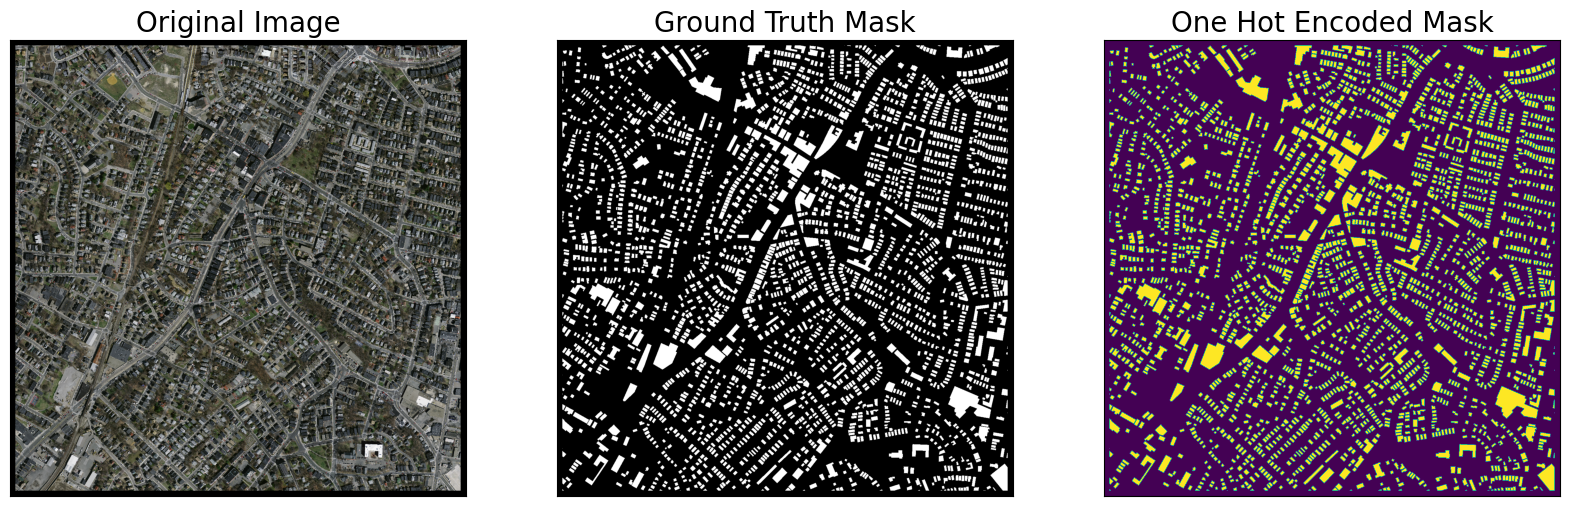

In [ ]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides.
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [ ]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[520,520,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

### Model Evaluation on Test Dataset

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")
print(f"FScore: {valid_logs['fscore']:.4f}")
print(f"Accuracy: {valid_logs['accuracy']:.4f}")
print(f"Recall: {valid_logs['recall']:.4f}")
print(f"Precision: {valid_logs['precision']:.4f}")

valid: 100%|██████████| 10/10 [00:25<00:00,  2.58s/it, dice_loss - 0.2835, iou_score - 0.7369, fscore - 0.8471, accuracy - 0.8479, recall - 0.8829, precision - 0.8141]
Evaluation on Test Data: 
Mean IoU Score: 0.7369
Mean Dice Loss: 0.2835
FScore: 0.8471
Accuracy: 0.8479
Recall: 0.8829
Precision: 0.8141


### Plot Dice Loss & IoU Metric for Train vs. Val

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2         3         4
dice_loss  0.415128  0.375454  0.342608  0.314758  0.288366
iou_score  0.555122  0.622644  0.673621  0.718433  0.754396
fscore     0.712959  0.766997  0.804607  0.835773  0.859334
accuracy   0.706000  0.763200  0.800368  0.831761  0.856106
recall     0.730039  0.779753  0.821856  0.856464  0.879326
precision  0.696724  0.754766  0.788148  0.816104  0.840252

In [ ]:
valid_logs_df.T

0         1         2         3         4
dice_loss  0.439943  0.354678  0.321404  0.280840  0.260591
iou_score  0.534104  0.705078  0.735230  0.780549  0.793099
fscore     0.693196  0.824478  0.844699  0.875472  0.883647
accuracy   0.691644  0.825361  0.845077  0.876086  0.884702
recall     0.733502  0.860236  0.882207  0.911925  0.917057
precision  0.657829  0.791686  0.810361  0.841896  0.852629

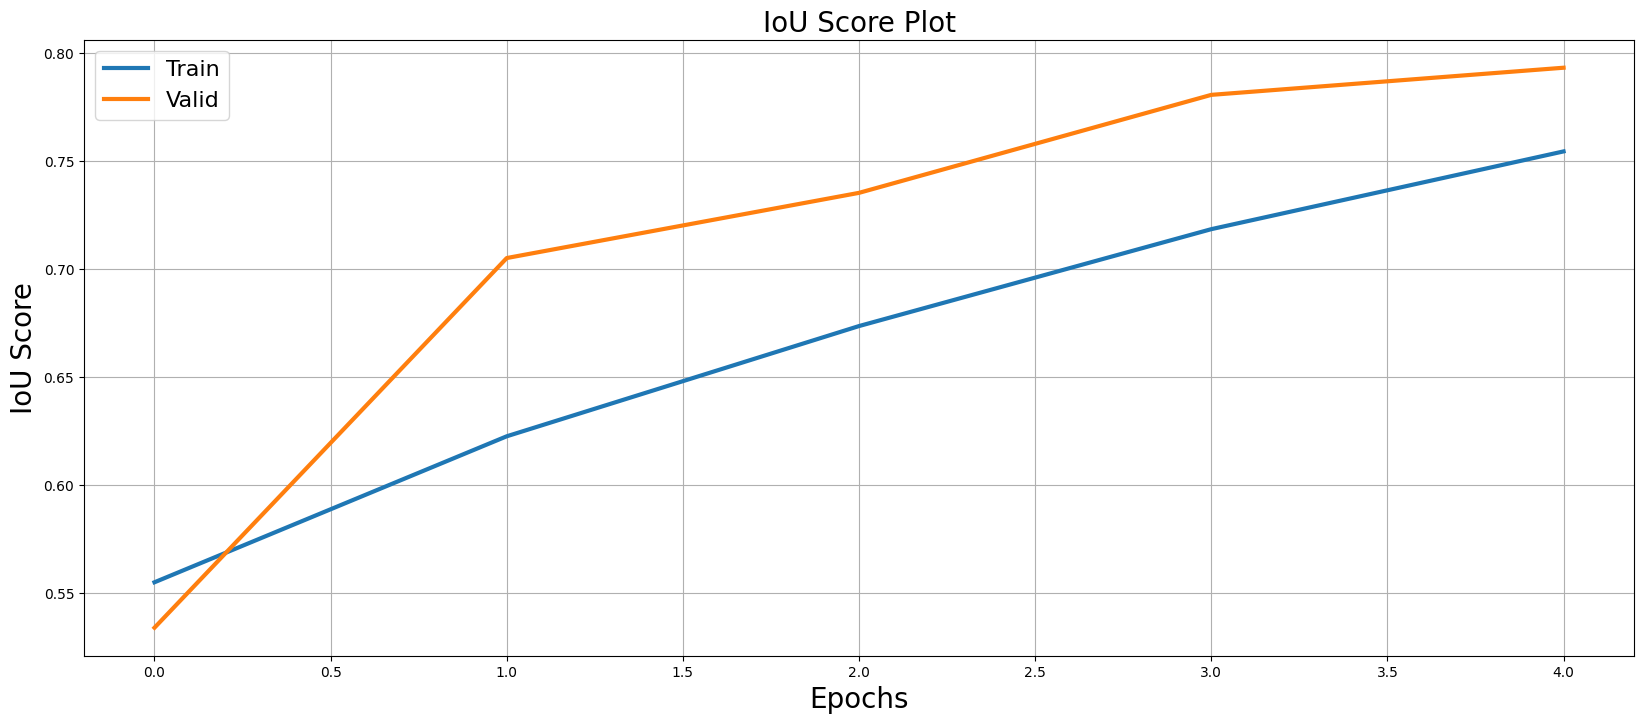

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

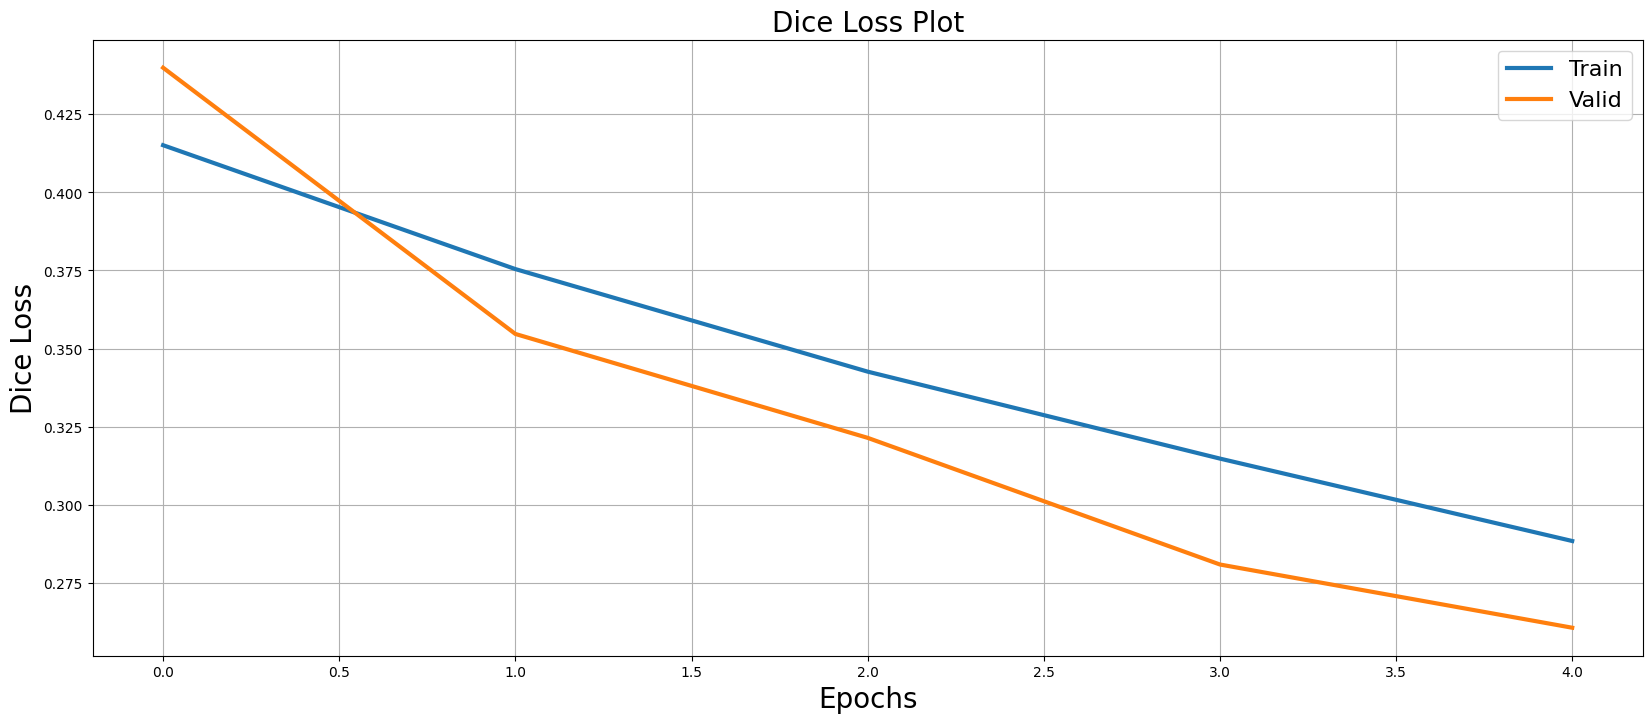

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

In [ ]:
for idx in range(2):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to road
    pred_building_heatmap = pred_mask[:,:,select_classes.index('building')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

OutOfMemoryError: CUDA out of memory. Tried to allocate 68.00 MiB. GPU 